# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

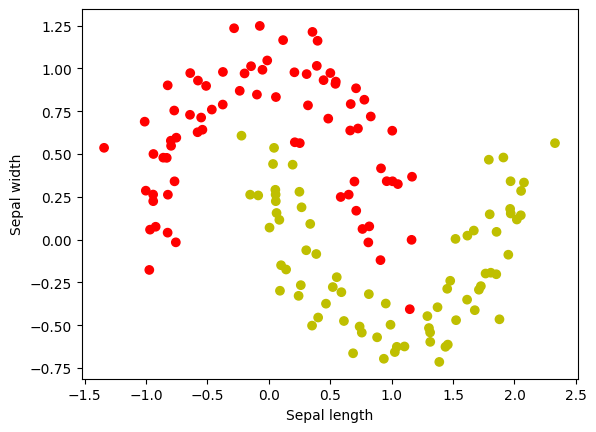

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [110]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3)
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [111]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [112]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [113]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0048)


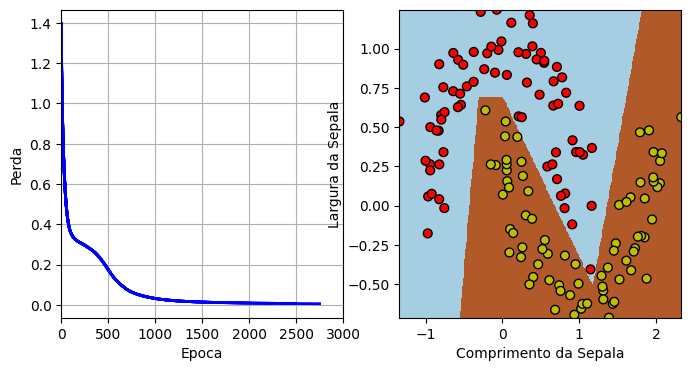

In [114]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.2600, -0.2877],
        [ 0.2530, -0.6972],
        [-1.8624,  0.9035],
        [ 0.1390,  0.7583],
        [ 0.2776,  0.8903]])
dense.0.bias    torch.Size([5])
tensor([-0.5681,  0.9301, -0.5525,  0.3779,  1.0352])
dense.2.weight  torch.Size([5, 5])
tensor([[-0.3649,  0.6232, -0.1651,  0.1144,  0.0415],
        [-0.0880,  0.7950, -0.6395, -0.2012,  0.6320],
        [-0.1221, -0.2835,  1.3455,  0.3614,  0.9558],
        [ 0.0131, -0.4777,  1.3672,  0.4191,  0.5000],
        [-0.0510,  0.0779, -0.0172, -0.1226, -0.4373]])
dense.2.bias    torch.Size([5])
tensor([-0.1681,  1.4896,  0.1817,  0.5028, -0.1541])
dense.4.weight  torch.Size([3, 5])
tensor([[-0.2238, -0.0090,  1.3976,  1.2475,  0.1541],
        [ 0.5392,  1.6543, -0.6259, -1.0609, -0.0694],
        [ 0.3135, -0.9488, -0.8344,  0.0953, -0.1242]])
dense.4.bias    torch.Size([3])
tensor([-0.0740,  0.8399, -0.7461])


### Avaliação do classificador

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.88


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,65,8
1,10,67


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

**Exercício 1**

Gráfico com 1 camada a mais

 Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

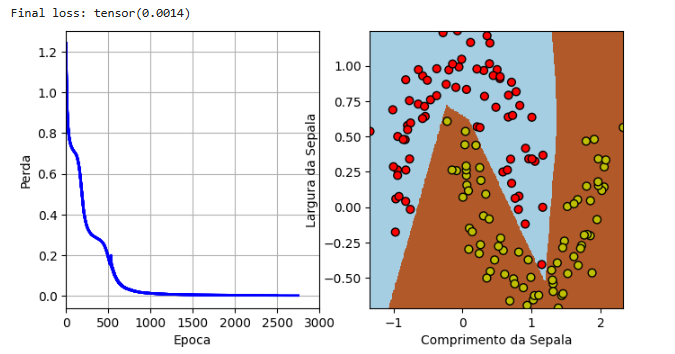

Gráfico com mais neurônios

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

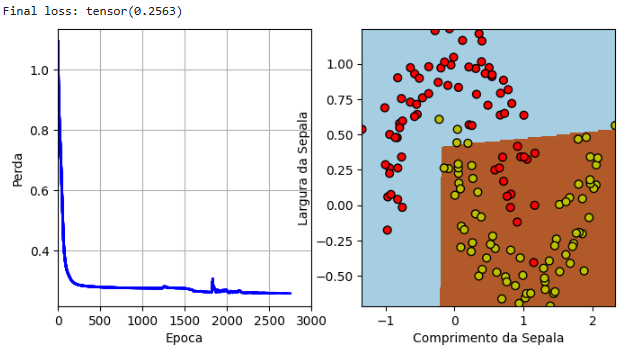

É possível observar que ao adicionar mais uma camada o treinamento melhorou visualmente em relação ao limite de seus respectivos grupos. Em contrapartida, ao aumentar a quantidade de neurônios o limite ficou totalmente equivocado, não conseguindo treinar muito bem

**2 - No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.**

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)

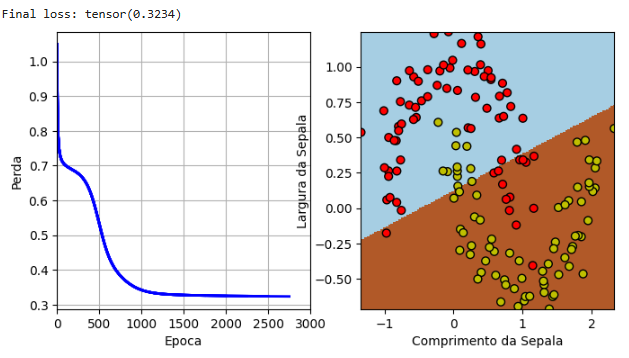

A função de ativação sigmoidal não conseguiu identificar muito bem a distruibuição dos dados no treinamento, retornando uma reta e assim tendo uma perda maior do que o ReLU.

In [ ]:
#3 - O que ocorre quando não se utiliza ativação não linear entre camadas?

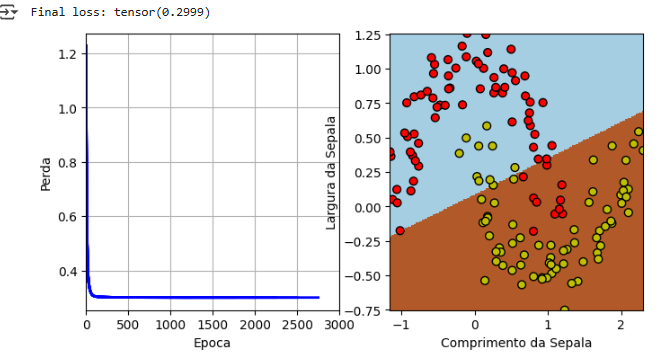

Os dados não são classificados com maior precisão do que com as camadas de ativação. É possível ver a distinção entre as duas classes por meio de uma reta linear indicando que quando apenas adicionamos camadas lineares elas não apresentam uma não linearidade.

## Principais aprendizados

* Utilização da camada de ativação em modelos lineares para gerar uma não linearidade e melhorar o treinamento das redes neurais